In [2]:
import sys
sys.path.append('../scripts/')
from puddle_world import *
import itertools

In [10]:
class PolicyEvaluator:
    def __init__(self, widths, goal, lowerleft = np.array([-4, -4]).T, upperright = np.array([4, 4]).T):
        self.pose_min = np.r_[lowerleft, 0]
        print("self.pose_min ",self.pose_min)
        self.pose_max = np.r_[upperright, math.pi * 2]
        print("self.pose_max ",self.pose_max)
        self.widths = widths
        
        self.goal = goal
        
        self.index_nums = ((self.pose_max - self.pose_min) / self.widths).astype(int) # x,y,θの三つのインデックス計算
        
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt))) # 直積 リストの作成
        
        self.value_function, self.final_state_flags = self.init_value_function()
        
        self.policy = self.init_policy()
        
    # 制御指令値を格納する三次元配列
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums, 2]) # 4次元にする
        for index in self.indexes:
            center = self.pose_min + self.widths * (np.array(index).T + 0.5) # セルの中心座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goal)
            
        return tmp
    
    # 初期化
    def init_value_function(self):
        v = np.empty(self.index_nums)
        f = np.zeros(self.index_nums)
        
        # 各離散状態が終端状態かどうか
        for index in self.indexes:
            f[index] = self.final_state(np.array(index).T) # 0 or 1
            v[index] = self.goal.value if f[index] else -100.0 # 終端状態でなければテキトーな値をいれる
            
        return v, f
    
    # ４隅全てがゴール範囲にいるかどうか
    def final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths * index # xy平面での左下の座標
        x_max, y_max, _ = self.pose_min + self.widths * (index + 1) # 右上の座標
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _]]
        return all ([self.goal.inside(np.array(c).T) for c in corners]) # 四つの角全部において、goal.inside が全てtrueかどうか

In [11]:
pe = PolicyEvaluator(np.array([0.2, 0.2, math.pi / 18]).T, Goal(-3,-3))

self.pose_min  [-4 -4  0]
self.pose_max  [4.         4.         6.28318531]


<IPython.core.display.Javascript object>


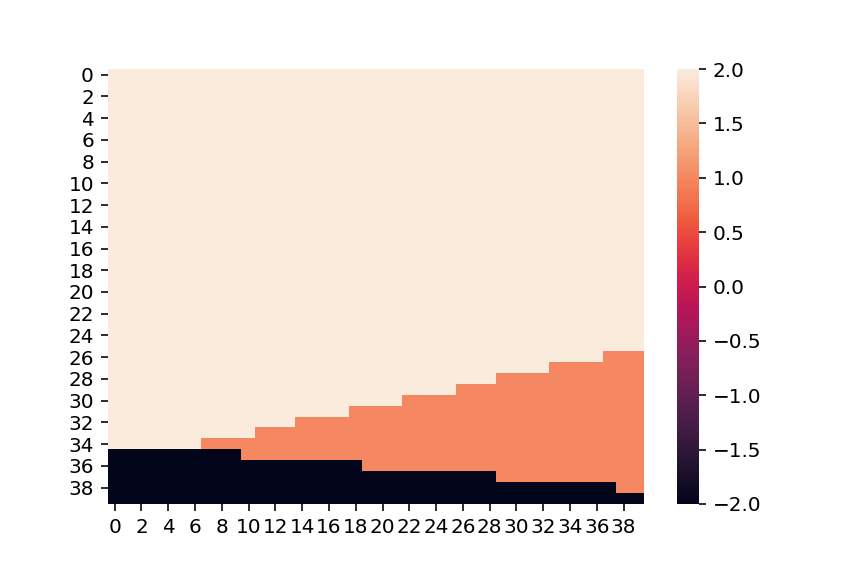

In [6]:
import seaborn as sns
p = np.zeros(pe.index_nums)
for i in pe.indexes:
    p[i] = sum(pe.policy[i]) # 速度と角速度を足すと、0.2: 直進 0,5: 左回転 -0.5: 右回転
    
sns.heatmap(np.rot90(p[:, :, 18]), square = False)
plt.show()

In [5]:
f = pe.final_state_flags[:, :, 0]
sns.heatmap(np.rot90(f), square = False)
plt.show()
# goalが１.０　あとは０.０